In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install plotly_express

## Goal
The goal of this notebook is essentially to recommend a driver's lifetime value (LTV). 

In [0]:
import os

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/lyft'
os.chdir(PATH)

DATA_DIR = os.path.join(PATH, 'data')

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly_express as px

import umap

import operator
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore')

## Read in

In [0]:
ride_timestamps = pd.read_csv(os.path.join(DATA_DIR, 'ride_timestamps.csv'))
ride_ids = pd.read_csv(os.path.join(DATA_DIR, 'ride_ids.csv'))
driver_ids = pd.read_csv(os.path.join(DATA_DIR, 'driver_ids.csv'))

In [6]:
ride_timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


In [7]:
ride_ids.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


In [8]:
driver_ids.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


## EDA

### `drivers_ids`

In [9]:
driver_ids['driver_id'].nunique() # len(driver_ids)

937

In [10]:
driver_ids['driver_onboard_date'].min(), driver_ids['driver_onboard_date'].max()

('2016-03-28 00:00:00', '2016-05-15 00:00:00')

The file `driver_ids.csv` consists of drivers who signed up as a driver with Lyft between 2016/03/28 to 2016/05/15.

### `ride_timestamps`

Check whether do the rides start after all the drivers have registered.

In [11]:
# convert timestamp to datetime object
ride_timestamps['timestamp'] = pd.to_datetime(ride_timestamps['timestamp'])

# check the min and max
ride_timestamps['timestamp'].min(), ride_timestamps['timestamp'].max()

(Timestamp('2016-03-28 05:48:18'), Timestamp('2016-06-27 00:50:50'))

The dataset for rides started on 2016/03/28 and ended on 2016/06/27. We proceed to perform feature engineering on the `timestamp` of each ride.

In [0]:
# Feature engineer time features
def add_datepart(df, fldname, drop=False, time=True):
    """
    Taken from fast.ai
    Helper function that adds columns relevant to a date.
    """
    import re 
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    if time: attr = attr + ['Hour', 'Minute']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [13]:
add_datepart(ride_timestamps, 'timestamp')

ride_timestamps.head()

,ride_id,event,timestamp,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,timestampHour,timestampMinute,timestampElapsed
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19,6.0,24.0,13.0,0.0,165.0,9.0,39.0,1465810759
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51,6.0,24.0,13.0,0.0,165.0,9.0,39.0,1465810791
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31,6.0,24.0,13.0,0.0,165.0,9.0,44.0,1465811071
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33,6.0,24.0,13.0,0.0,165.0,9.0,44.0,1465811073
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05,6.0,24.0,13.0,0.0,165.0,10.0,3.0,1465812185


One of the features we deem important later to perform segmenting on drivers is how long does a driver take, on average, to accept a ride. To do so, we have to calculate the time lag between a ride was requested `event == 'requested_at'` to the time the driver accepted the ride `event == 'accepted_at'`.

We hypothesize that keen drivers who are more likely to have a short window between those two events. We call this new feature `pickup_window`.

In [0]:
# calculate time lag wrt to `requested_at`
def seconds_lag(t):
    delta_to_t0 = t - t.iloc[0]
    return delta_to_t0

In [15]:
%%time
ride_timestamps['pickup_window'] = ride_timestamps.groupby('ride_id')['timestamp'].apply(seconds_lag)

ride_timestamps['pickup_window'] = ride_timestamps['pickup_window'].apply(lambda o: o.total_seconds())

CPU times: user 1min 56s, sys: 3.6 s, total: 1min 59s
Wall time: 1min 56s


In [16]:
ride_timestamps.head()

,ride_id,event,timestamp,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,timestampHour,timestampMinute,timestampElapsed,pickup_window
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19,6.0,24.0,13.0,0.0,165.0,9.0,39.0,1465810759,0.0
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51,6.0,24.0,13.0,0.0,165.0,9.0,39.0,1465810791,32.0
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31,6.0,24.0,13.0,0.0,165.0,9.0,44.0,1465811071,312.0
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33,6.0,24.0,13.0,0.0,165.0,9.0,44.0,1465811073,314.0
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05,6.0,24.0,13.0,0.0,165.0,10.0,3.0,1465812185,1426.0


In [17]:
# filter only `event == 'accepted_at'`
accepted_filter = ride_timestamps[ride_timestamps['event'] == 'accepted_at']

# merge to `ride_ids` to get `driver_id`
driver_accepted_filter = pd.merge(accepted_filter, ride_ids,
                                  on='ride_id')

# calculate mean based on `driver_id`
window_g = driver_accepted_filter.groupby('driver_id')['pickup_window'].mean()

window_g = window_g.reset_index()

window_g.head()

,driver_id,pickup_window
0,002be0ffdc997bd5c50703158b7c2491,8.407942
1,007f0389f9c7b03ef97098422f902e62,11.838710
2,011e5c5dfc5c2c92501b8b24d47509bc,7.294118
3,0152a2f305e71d26cc964f8d4411add9,14.198953
4,01674381af7edd264113d4e6ed55ecda,12.528000


In [18]:
# d = pd.merge(ride_ids, ride_timestamps, on='ride_id', how='inner')
# d['driver_id'].nunique() # check that the values do not match

len(window_g), ride_ids['driver_id'].nunique()

(844, 937)

There are 93 drivers in `ride_ids` who do not have records in `ride_timestamps`.

## `ride_ids`
We would like to get an idea of how many rides has a driver completed over the course of the dataset. We call this feature `ride_count`. It will also be a crucial variable to calculate LTV later.

In [19]:
# calculate the total rides a driver has completed
ride_id_g = ride_ids.groupby('driver_id')['ride_id'].count()

ride_id_g = ride_id_g.reset_index()

ride_id_g.rename(columns={'ride_id': 'ride_count'}, inplace=True)

ride_id_g.sort_values(by='ride_count', ascending=False).head()

,driver_id,ride_count
354,5ccc0e6dc9c7475caf785cdce7b8eb7a,919
308,4eb382d1f7d50fae1294964263d1ce82,831
509,844e9be5a30d8d9c1f8e9ddb086ff717,821
401,689bdf87fb2de49f98bf4946cfaa5068,794
217,3788dc9e91f1548816ce8b5af07ddadc,783


In [20]:
# check how many `driver_id` are there in both dataframes
driver_ids['driver_id'].nunique(), ride_ids['driver_id'].nunique()

(937, 937)

In [21]:
len(set(driver_ids['driver_id'].unique().tolist()).intersection(set(ride_ids['driver_id'].unique().tolist())))

854

In [22]:
# how many unique `driver_id`s appear in `driver_ids`
num_missing_drivers = len(driver_ids[~driver_ids['driver_id'].isin(ride_ids['driver_id'].unique())])

num_missing_drivers

83

Interestingly, even we have 937 unique `driver_id`s for both `driver_ids` and `ride_ids`, only 854 overlap. That means, 83 drivers that appear in `ride_ids` do not have any record in `driver_ids`. We suspect that those drivers registered earlier than the start of the dataset. For the 83 drivers that appear in `driver_ids` but not in `ride_ids`, we suspect they registered but did not drive. They shall be removed from our analysis.

In [23]:
ride_timestamps['ride_id'].nunique(), ride_ids['ride_id'].nunique()

(194081, 193502)

In [24]:
# check how many rides actually appear in both dataframes
len(set(ride_timestamps['ride_id'].unique().tolist()).intersection(set(ride_ids['ride_id'].unique().tolist())))

184819

Only 184,819 unique `ride_id`s exist in `ride_timestamps` and `ride_ids`.

To calculate the fare, we first convert the `ride_distance` from metres to mile and convert the `ride_duration` from seconds to minutes.

In [0]:
# convert metres to miles
ride_ids['ride_distance'] = ride_ids['ride_distance'] / 1609.34

# convert seconds to minutes
ride_ids['ride_duration'] = ride_ids['ride_duration'] / 60

To calculate the fare, we employed the assumptions about the Lyft rate card in the prompt. The formula we use is as follows:

\begin{equation}
\begin{aligned}
\text{Fare} 
& = (\text{base fare} + 
\text{cost per mile}  \times  \text{miles traveled} + 
\text{cost per min} \times \text{mins traveled}) (1 + \frac{\text{prime time}}{100}) + \text{service fee} \\
& = (2 + 
1.15 \times  \text{miles traveled} + 
0.22 \times \text{mins traveled})  (1 + \frac{\text{prime time}}{100}) + 1.75 
\end{aligned}
\end{equation}

After calculating the fare, we limited the lower bound of the fare to 5 USD and the upper of the fare to 400 USD.

\begin{equation}
\text{Fare} = \text{min}\{400, \text{max}\{5,\text{fare}\}\}
\end{equation}

In [26]:
ride_ids['fare'] = (2 + 
                     ride_ids['ride_distance'] * 1.15 + 
                     ride_ids['ride_duration'] * 0.22) * \
                    ((ride_ids['ride_prime_time'] + 100) / 100) \
                    + 1.75 

def limit_bound(fare):
    return min(max(5, fare), 400)

ride_ids['fare'] = ride_ids['fare'].apply(limit_bound)

ride_ids['fare'].describe()

count    193502.000000
mean         13.536544
std           9.881417
min           5.000000
25%           8.036033
50%          10.571234
75%          15.115603
max         400.000000
Name: fare, dtype: float64

In [27]:
fare_g = ride_ids.groupby('driver_id')['fare'].sum()

fare_g = fare_g.reset_index()

fare_g.sort_values(by='fare', ascending=False).head()

,driver_id,fare
354,5ccc0e6dc9c7475caf785cdce7b8eb7a,12350.288077
217,3788dc9e91f1548816ce8b5af07ddadc,12304.887351
308,4eb382d1f7d50fae1294964263d1ce82,10781.942344
412,6b65c06851e944351dd285a1eb729499,10708.943770
509,844e9be5a30d8d9c1f8e9ddb086ff717,10613.901682


We then calculated the sum of the fare for each driver. This will be the total income generated by the driver.

Next, we think that the higher a driver's `ride_prime_time`, the more her or she is valuable to Lyft since they help to meet passengers' demand. This could be another important feature for segmenting drivers. Since we are only interested in the mean of the nonzero `ride_prime_time` values and we do not want 0 values to distort the `ride_prime_time` lower, we replace all zeros with `NaN`.

In [28]:
# make the variable NaN to calculate mean
ride_ids['ride_prime_time'].replace(0, np.nan, inplace=True)

ride_prime_time_g = ride_ids.groupby('driver_id')['ride_prime_time'].mean()

ride_prime_time_g = ride_prime_time_g.reset_index()

ride_prime_time_g.sort_values(by='ride_prime_time', ascending=False).head()

,driver_id,ride_prime_time
807,dae249fc394c9bdf02f7d8bb1ff55733,146.875000
676,b2d3f2fb171a12cac427107690c10089,105.000000
420,6cb35e276085548f3f095a85aa63af7b,98.076923
443,7419cd5c573ff9994c0f8ff5d92b4408,91.071429
655,acd7dc6118befb6724aa3752d1cdbea1,90.277778


In [0]:
# change back to original value
ride_prime_time_g['ride_prime_time'].fillna(0, inplace=True)

Merge both `driver_ids` and `driver_timestamps`.

In [30]:
ids_timestamps = pd.merge(ride_ids, ride_timestamps,
                          left_on='ride_id',
                          right_on='ride_id',
                          how='outer')

ids_timestamps = ids_timestamps.sort_values(by=['driver_id', 'timestamp'])

ids_timestamps.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,fare,event,timestamp,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,timestampHour,timestampMinute,timestampElapsed,pickup_window
1235,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,requested_at,2016-03-29 18:46:50,3.0,13.0,29.0,1.0,89.0,18.0,46.0,1.459277e+09,0.0
1236,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,accepted_at,2016-03-29 18:47:01,3.0,13.0,29.0,1.0,89.0,18.0,47.0,1.459277e+09,11.0
1237,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,arrived_at,2016-03-29 18:50:00,3.0,13.0,29.0,1.0,89.0,18.0,50.0,1.459277e+09,190.0
1238,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,picked_up_at,2016-03-29 18:50:01,3.0,13.0,29.0,1.0,89.0,18.0,50.0,1.459277e+09,191.0
1239,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,dropped_off_at,2016-03-29 18:55:47,3.0,13.0,29.0,1.0,89.0,18.0,55.0,1.459278e+09,537.0


Since part-time drivers should have a lower LTV compared to full-time drivers, we hypothesize that drivers who drive mainly on weekends are part-time drivers.

In [31]:
# Monday 0, Sunday 6
# create variable `is_weekday`
ids_timestamps['is_weekday'] = 0 

# assign values < 5 to 1 for all weekdays
ids_timestamps.loc[ids_timestamps['timestampDayofweek'] < 5, 'is_weekday'] = 1

weekday_drivers_g = ids_timestamps.groupby('driver_id')['is_weekday'].mean()

weekday_drivers_g = weekday_drivers_g.reset_index()

weekday_drivers_g.sort_values(by='is_weekday').head()

,driver_id,is_weekday
870,ea71f79a86672486e018deeb47a545ec,0.0
296,4bbf15c7280e29c1df6edd7bf6dfa56a,0.0
108,1cf6fa07dcec364af2acf257b2d3731e,0.0
732,c64e642876910be4a1f0b57404dc9710,0.0
210,364c929f1d6535aa17df83ebcb349e87,0.0


In [32]:
# check for an example
ids_timestamps[ids_timestamps['driver_id'] == 'ea71f79a86672486e018deeb47a545ec']['ride_id'].nunique()

72

Driver `ea71f79a86672486e018deeb47a545ec` made 72 rides in the entire dataset and all rides only happen on weekends.

Next, we look into drivers who prefer to drive in the morning v.s. drivers who prefer to drive at night. We define `is_late_ride` as rides that happen between 11:00 PM and 6:00 AM.

In [33]:
ids_timestamps['is_late_ride'] = 0 

# if time is after 11 PM and before 6 AM,
# assign value `is_late_ride` to 1
ids_timestamps.loc[(ids_timestamps['timestampHour'] >= 23) |
                   (ids_timestamps['timestampHour'] <= 6), 
                   'is_late_ride'] = 1

# calculate the mean based on drivers
# to compute how often they drive at late night
is_late_ride_g = ids_timestamps.groupby('driver_id')['is_late_ride'].mean()

is_late_ride_g = is_late_ride_g.reset_index()

is_late_ride_g.sort_values(by='is_late_ride', ascending=False).head()

,driver_id,is_late_ride
523,8969d175c4676642b245af55d2dba19b,0.903448
222,3857da988688981b67c878fc179eb0dc,0.898947
551,905f8007cd46415eba8b9dce088b4395,0.891892
466,793e2072826ee96904a5f03ae2357e96,0.873927
77,175540c364f94b6adbc0ce3541a3254a,0.870370


In [34]:
# check an example
ids_timestamps[ids_timestamps['driver_id'] == '3857da988688981b67c878fc179eb0dc']['ride_id'].nunique()

190

Driver `3857da988688981b67c878fc179eb0dc` completed 190 rides in the entire dataset and on most of the rides are completed at night.

Next, we create a feature `drop_requested_lag` to measure how fast do drivers pick up the next ride after they drop off passengers. The feature `drop_requested_lag` only considers same day pickups. So there exists a condition that a driver only picks up a passenger a day and this might lead to low `drop_requested_lag` value.

In [35]:
# Shift the `timestamp` down 1 row
# and subtract the `timestamp_shift` from `timestamp`
# to measure the lag between a `dropped_off_at` and request time.
# Since most request time is relatively close to pickup time,
# this can be a good proxy.
ids_timestamps['timestamp_shift'] = ids_timestamps.groupby('driver_id')['timestamp'].apply(lambda o: o.shift())

ids_timestamps['delta_timestamp'] = ids_timestamps['timestamp'] - ids_timestamps['timestamp_shift']

ids_timestamps.head(8)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,fare,event,timestamp,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,timestampHour,timestampMinute,timestampElapsed,pickup_window,is_weekday,is_late_ride,timestamp_shift,delta_timestamp
1235,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,requested_at,2016-03-29 18:46:50,3.0,13.0,29.0,1.0,89.0,18.0,46.0,1.459277e+09,0.0,1,0,NaT,NaT
1236,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,accepted_at,2016-03-29 18:47:01,3.0,13.0,29.0,1.0,89.0,18.0,47.0,1.459277e+09,11.0,1,0,2016-03-29 18:46:50,00:00:11
1237,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,arrived_at,2016-03-29 18:50:00,3.0,13.0,29.0,1.0,89.0,18.0,50.0,1.459277e+09,190.0,1,0,2016-03-29 18:47:01,00:02:59
1238,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,picked_up_at,2016-03-29 18:50:01,3.0,13.0,29.0,1.0,89.0,18.0,50.0,1.459277e+09,191.0,1,0,2016-03-29 18:50:00,00:00:01
1239,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,dropped_off_at,2016-03-29 18:55:47,3.0,13.0,29.0,1.0,89.0,18.0,55.0,1.459278e+09,537.0,1,0,2016-03-29 18:50:01,00:05:46
5,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089055,13.483333,NaN,9.118747,requested_at,2016-03-29 19:00:49,3.0,13.0,29.0,1.0,89.0,19.0,0.0,1.459278e+09,0.0,1,0,2016-03-29 18:55:47,00:05:02
6,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089055,13.483333,NaN,9.118747,accepted_at,2016-03-29 19:00:52,3.0,13.0,29.0,1.0,89.0,19.0,0.0,1.459278e+09,3.0,1,0,2016-03-29 19:00:49,00:00:03
7,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089055,13.483333,NaN,9.118747,arrived_at,2016-03-29 19:03:57,3.0,13.0,29.0,1.0,89.0,19.0,3.0,1.459278e+09,188.0,1,0,2016-03-29 19:00:52,00:03:05


In [0]:
# If the `event == 'request_at'` and the `delta_timestamp` is not null, 
# this indicates that this is not the first ride of the day.
# Assign boolean value of 1 to `drop_requested_lag`. 
ids_timestamps.loc[(ids_timestamps['event'] == 'requested_at') &
                   (~ids_timestamps['delta_timestamp'].isna()), 'drop_requested_lag'] = 1

ids_timestamps['drop_requested_lag'].fillna(0, inplace=True)

# Since `drop_requested_lag` for all the second rides onwards 
# of a particular day has value = 1, we can directly "transfer" the values
# of `delta_timestamp` over. 
# `drop_requested_lag` only has values for all the second rides onwards 
# as a time lag from the previous `dropoff_at`
ids_timestamps['drop_requested_lag'] = ids_timestamps['drop_requested_lag'] * ids_timestamps['delta_timestamp']

# convert the time to seconds
ids_timestamps['drop_requested_lag'] = ids_timestamps['drop_requested_lag'].apply(lambda o: o.total_seconds())

# only consider same day lags
ids_timestamps.loc[ids_timestamps['delta_timestamp'].dt.days > 0, 'drop_requested_lag'] = np.nan

In [37]:
# filter only `event == 'requested_at'` 
filtered_requested_at = ids_timestamps[ids_timestamps['event'] == 'requested_at']

# calculate the mean
drop_requested_lag_g = filtered_requested_at.groupby('driver_id')['drop_requested_lag'].mean()

drop_requested_lag_g = drop_requested_lag_g.reset_index()

drop_requested_lag_g.sort_values(by='drop_requested_lag').head()

,driver_id,drop_requested_lag
441,7ff85c5c0e9324e28d1e0d0589c364bd,181.000000
526,9a54684a69721c1075c2af5fc077665b,754.351351
495,905f8007cd46415eba8b9dce088b4395,936.774194
226,42256e33936dfa69088f540a720edc97,942.870968
313,5cf93f7d1d3a8f0cf395c84053c31b1b,976.818182


Merge `ids_timestamps` with `driver_id`.

In [0]:
df = pd.merge(ids_timestamps, driver_ids,
              left_on='driver_id', right_on='driver_id',
              how='outer')

In [0]:
# df.isna().sum()

To calculate how many actual days did the driver drive, we calculate the number of unique days the driver has activity.

In [40]:
# only get the date from timestamp
df['date'] = df['timestamp'].dt.date

# calculate how many unique dates are there
unique_dates_g = df.groupby('driver_id')['date'].nunique()

unique_dates_g = unique_dates_g.reset_index()

unique_dates_g.rename(columns={'date': 'unique_days'}, inplace=True)

unique_dates_g.head()

,driver_id,unique_days
0,002be0ffdc997bd5c50703158b7c2491,56
1,007f0389f9c7b03ef97098422f902e62,12
2,011e5c5dfc5c2c92501b8b24d47509bc,12
3,0152a2f305e71d26cc964f8d4411add9,42
4,01674381af7edd264113d4e6ed55ecda,40


In [41]:
t = pd.merge(ids_timestamps, driver_ids,
              left_on='driver_id', right_on='driver_id', how='outer')

# for all the entries that do not have a `driver_id`
# check how many unique `ride_id`s are there
t[t['driver_id'].isna()]['ride_id'].nunique()

9262

Since the `unique_days` is dependent on activities from `ride_timestamps`, we decide to fill the 0 values with the mean because these drivers altogether complete 9,262 rides.

In [0]:
unique_dates_g['unique_days'].replace(0, unique_dates_g['unique_days'].mean(), inplace=True)

Next, we create the feature `driving_period` to account for the duration between the last trip a driver made and the day the driver was onboard. 

In [0]:
# tail(1) gets the last activity
# we subtract the onboard date with the last activity
df['driving_period'] = (df.groupby('driver_id')['timestamp'].tail(1) - pd.to_datetime(df['driver_onboard_date'])).dt.days

To calculate the average churn rate, we first get the driver's last activity based on `timestamp` in `ride_timestamps`. Since the last day of the `timestamp` in `ride_timestamps` was 2016/06/27, we calculate the number of days since the driver's last activity with respect to the last day of the dataset. We assume drivers who have more than 7 days of inactivity have churned.

In [0]:
# we now take the last date of the dataset
# and subtract the last activity from it
df['last_activity'] = (df['timestamp'].max() - df.groupby('driver_id')['timestamp'].tail(1)).dt.days

last_activity_df = df.groupby('driver_id').tail(1)

In [45]:
# check how many drivers have a `last_activity` of > 7
len(last_activity_df[last_activity_df['last_activity'] > 7])

309

There are 309 drivers whose last activity was more than 7 days. Meanwhile, for the 93 drivers who have no record in `ride_timestamps`, all of them together completed 9,262 trips. We assume that they have not churned.

In [46]:
# since the drivers have completed 9,262 rides,
# we assume they have not churned
churn_rate = len(last_activity_df[last_activity_df['last_activity'] > 7]) / len(driver_ids)

churn_rate

0.3297758804695838

We proceed to create a bar plot of number of active drivers.

In [0]:
# get the earliest timestamp of a driver's activity
first_day = ids_timestamps.groupby('driver_id')['timestamp'].min().reset_index()
first_day.rename(columns={'timestamp': 'first_day'}, inplace=True)

# get the latest timestamp of a driver's activity
last_day = ids_timestamps.groupby('driver_id')['timestamp'].max().reset_index()
last_day.rename(columns={'timestamp': 'last_day'}, inplace=True)

# create a dataframe that includes both first and last day
first_last_day = pd.merge(first_day, last_day, on='driver_id')

# if the last day of activity is less than 7 days of the
# last day of the dataset, change the last day to the last 
# day of the dataset 
first_last_day.loc[((df['timestamp'].max() - first_last_day['last_day']).dt.days <= 7),
                   'last_day'] = df['timestamp'].max()

In [48]:
first_last_day.head()

,driver_id,first_day,last_day
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 18:46:50,2016-06-27 00:50:50
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 22:28:28,2016-06-27 00:50:50
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 10:54:51,2016-06-12 20:30:38
3,0152a2f305e71d26cc964f8d4411add9,2016-04-25 15:59:20,2016-06-27 00:50:50
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 07:50:40,2016-06-27 00:50:50


In [0]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

date_count = {}

# for each day between the first and last day
# calculate how many drivers' activities are there
for day in daterange(first_last_day['first_day'].min(), first_last_day['last_day'].max()):
    between = first_last_day[(first_last_day['first_day'] <= day) & (first_last_day['last_day'] >= day)]
    date_count[day] = len(between)

In [50]:
# create a dataframe from the dict we saved
retention = pd.DataFrame(date_count.items())

# rename the variables
retention.rename(columns={0: 'date',
                          1: 'num_drivers_onboard'}, inplace=True)

# keep only the month and day
retention['date'] = retention['date'].apply(lambda o: o.strftime('%m-%d'))

retention.head()

,date,num_drivers_onboard
0,03-28,1
1,03-29,21
2,03-30,48
3,03-31,70
4,04-01,92


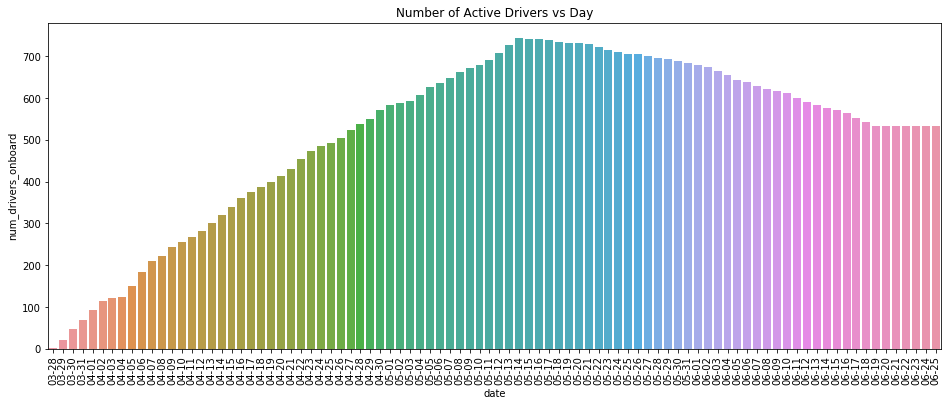

In [51]:
plt.figure(figsize=(16,6))
plt.title('Number of Active Drivers vs Day')
sns.barplot(x=retention['date'],
            y=retention['num_drivers_onboard'])
plt.xticks(rotation=90)
plt.show()

The graph flattens out because we assumed drivers who have less than 7 days of inactivity have not churned, but rather, are taking a break.

Since having days on the x-axis would be too compact, we also create a plot with week on the x-axis.

In [0]:
N = 7
weekly_retention = retention.groupby(retention.index // N).mean()

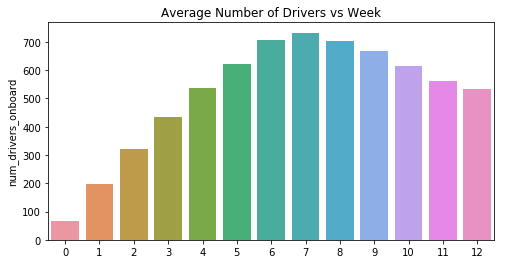

In [53]:
plt.figure(figsize=(8,4))
plt.title('Average Number of Drivers vs Week')
sns.barplot(x=np.arange(len(weekly_retention)),
            y=weekly_retention['num_drivers_onboard'])
plt.show()

In [54]:
# saves the driver who has the last timestamp
# present in `df`
onboard_period = df[~df['driving_period'].isna()]

onboard_period = onboard_period[['driver_id', 'driving_period']].copy()

onboard_period.sort_values('driving_period').head()

,driver_id,driving_period
722279,bd057e02f75c92917389d90bb215fe91,1.0
409829,68b546b2f4102641d6774c1ce4f57457,1.0
434419,6eb2e0f41fc9f1fbb70e7751035fdf87,1.0
615520,a2334fdb829cf96fbae920df0cce1587,2.0
849382,e4f3a9d5cf57b9b518136afd9757f76d,3.0


We then calculated the number of rides based on drivers per week.

In [0]:
df = df[~df['driver_onboard_date'].isna()]

# filter `event == 'dropped_off_at'` 
drop_off = df[df['event'] == 'dropped_off_at']

# bin the date into weeks
# based on every 7-day
drop_off['week'] = ((drop_off['timestamp'] - pd.to_datetime(drop_off['driver_onboard_date'])).dt.days / 7).astype(int)

In [56]:
drop_off.groupby('driver_id')['week'].value_counts().unstack().reset_index().fillna(0).head(10)

week,driver_id,0,1,2,3,4,5,6,7,8,9,10,11,12
0,002be0ffdc997bd5c50703158b7c2491,26.0,13.0,41.0,29.0,3.0,10.0,3.0,26.0,14.0,42.0,37.0,16.0,17.0
1,007f0389f9c7b03ef97098422f902e62,1.0,1.0,0.0,5.0,6.0,3.0,0.0,6.0,0.0,5.0,0.0,2.0,2.0
2,011e5c5dfc5c2c92501b8b24d47509bc,7.0,4.0,0.0,1.0,5.0,2.0,5.0,5.0,0.0,5.0,0.0,0.0,0.0
3,0152a2f305e71d26cc964f8d4411add9,23.0,14.0,15.0,4.0,15.0,31.0,19.0,28.0,32.0,10.0,0.0,0.0,0.0
4,01674381af7edd264113d4e6ed55ecda,45.0,48.0,30.0,53.0,43.0,42.0,52.0,53.0,9.0,0.0,0.0,0.0,0.0
5,0213f8b59219e32142711992ca4ec01f,26.0,43.0,60.0,73.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,021e5cd15ef0bb3ec20a12af99e142b3,4.0,14.0,8.0,8.0,2.0,0.0,12.0,5.0,0.0,0.0,0.0,0.0,0.0
7,0258e250ca195cc6258cbdc75aecd853,17.0,23.0,21.0,49.0,27.0,31.0,55.0,39.0,40.0,0.0,0.0,0.0,0.0
8,028b5a4dcd7f4924ebfabcf2e814c014,34.0,51.0,27.0,55.0,62.0,76.0,35.0,23.0,0.0,0.0,0.0,0.0,0.0
9,02d6a6b8a6da15fc219a9570f7ebbe78,15.0,5.0,9.0,2.0,3.0,9.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0


The table above shows the `driver_id` and its correponding rides given from week 0 to week 12. It seems like drivers are not so consistent in their driving behaviors.

## LTV
We next calculate the LTV for drivers.

In [0]:
# copy over the dataframe of `driver_id` and the number of rides completed
ltv = ride_id_g

# features we created
to_merge = (drop_requested_lag_g, ride_prime_time_g, fare_g, 
            onboard_period, window_g, unique_dates_g,
            weekday_drivers_g, is_late_ride_g)

# combine all features together
for ser in to_merge:
    ltv = pd.merge(ltv, ser, on='driver_id', how='outer')

In [58]:
ltv.isna().sum()

driver_id               0
ride_count             83
drop_requested_lag    177
ride_prime_time        83
fare                   83
driving_period        184
pickup_window         176
unique_days             0
is_weekday             83
is_late_ride           83
dtype: int64

If `driver_id` exists but `ride_id` does not exist, we assume the drivers registered but did not give any ride. From the above, we can tell they are the 83 drivers do not have `ride_count`. Hence, we remove these drivers from our analysis since they are the drivers that registered but did not drive.

In [0]:
ltv = ltv[~ltv['ride_count'].isna()]

It is hard to decide a driver's `drop_requested_lag` if he or she does not have any record of ride in `ride_timestamps`. Recall that these drivers altogether complete 9,262 rides. Hence, we decide to impute the `drop_requested_lag`'s `NaN`s as the mean of all `drop_requested_lag`. Same goes for all features that require entries in `ride_timestamps` for calculation as follows.

In [0]:
ltv['unique_days'].fillna(ltv['unique_days'].mean(), inplace=True)
ltv['unique_days'].replace(0, ltv['unique_days'].mean(), inplace=True)

ltv['drop_requested_lag'].fillna(ltv['drop_requested_lag'].mean(), inplace=True)

ltv['driving_period'].fillna(ltv['driving_period'].mean(), inplace=True)

ltv['pickup_window'].fillna(ltv['pickup_window'].mean(), inplace=True)

In [61]:
ltv.isna().sum()

driver_id             0
ride_count            0
drop_requested_lag    0
ride_prime_time       0
fare                  0
driving_period        0
pickup_window         0
unique_days           0
is_weekday            0
is_late_ride          0
dtype: int64

In [62]:
ltv.head()

,driver_id,ride_count,drop_requested_lag,ride_prime_time,fare,driving_period,pickup_window,unique_days,is_weekday,is_late_ride
0,002be0ffdc997bd5c50703158b7c2491,277.0,6594.516129,48.863636,3560.926071,86.0,8.407942,56.0,0.769675,0.238989
1,007f0389f9c7b03ef97098422f902e62,31.0,4615.550000,52.083333,321.494948,85.0,11.838710,12.0,0.709677,0.000000
2,011e5c5dfc5c2c92501b8b24d47509bc,34.0,7185.041667,42.187500,482.428390,68.0,7.294118,12.0,0.529412,0.058824
3,0152a2f305e71d26cc964f8d4411add9,191.0,10028.796610,42.708333,2610.871561,64.0,14.198953,42.0,0.796859,0.459686
4,01674381af7edd264113d4e6ed55ecda,375.0,6633.404372,47.474747,5381.097539,56.0,12.528000,40.0,1.000000,0.054933


## Questions
* What are the main factors that affect a driver's lifetime value?
* What is the average projected lifetime of a driver? That is, once a driver is
onboarded, how long do they typically continue driving with Lyft?
* Do all drivers act alike? Are there specific segments of drivers that generate more
value for Lyft than the average driver?
* What actionable recommendations are there for the business?

To calculate LTV, we referred to https://blog.hubspot.com/service/how-to-calculate-customer-lifetime-value. We define the variables as follows:

\begin{equation}\text{LTV} = \frac{\text{Average Income Generated by Driver}}{\text{Churn Rate}} \times 365 
\end{equation}


\begin{equation}
\text{Average Income Generated by a Driver} = \frac{\text{Total income generated by a driver}}{\text{Number of days the driver drove}}
\end{equation}


\begin{equation}
\text{Churn Rate} = \frac{\text{Number of drivers who have stopped driving}}{\text{Total number of drivers}} \times 100\%
\end{equation}



In [0]:
ltv['average_ride_val'] = ltv['fare'] / ltv['ride_count']

ltv['average_ride_freq'] = ltv['ride_count'] / ltv['unique_days']

ltv['average_val'] = ltv['average_ride_val'] * ltv['average_ride_freq']

ltv['ltv'] = ltv['average_val'] * 365 / churn_rate

To study how "predictive" the features we engineered, we decided to apply KMeans algorithm to only a the features used to calculate `ltv`. We call them `base_metrics`. It comprises of `ride_count`, `fare`, `unique_days`, and `ltv`.

In [64]:
# only use base metrics for KMeans
base_metrics = ['ride_count', 'fare', 'unique_days', 'ltv']

ltv[['driver_id'] + base_metrics].sort_values(by='ltv', ascending=False).head()

,driver_id,ride_count,fare,unique_days,ltv
412,6b65c06851e944351dd285a1eb729499,718.0,10708.943770,45.0,263395.348015
217,3788dc9e91f1548816ce8b5af07ddadc,783.0,12304.887351,56.0,243200.011467
156,297e507cc9f1da096e51c2223657255b,588.0,8657.558363,40.0,239557.301603
318,51b528390e8e7780595f6009b1f4cf72,240.0,3018.980483,14.0,238674.623214
426,6eb2e0f41fc9f1fbb70e7751035fdf87,35.0,421.815299,2.0,233435.180156


The main factors that affect lifetime value (LTV) are the number of rides a driver has completed, `ride_count`, total revenue generated by the driver, `fare` and the number of days the driver worked, `unique_days`.

In [65]:
1 / churn_rate

3.0323624595469254

We take average lifetime as the inverse of churn rate. Hence, we predict the average lifetime for drivers is approximately 3.03 years.

## KMeans Clustering
We performing KMeans Clustering to segment the drivers. Silhoutte score is then used to find the optimal K, in our case, where K=3 produces the best result. We will now test whether do our engineered features, such as `is_weekday`, `is_late_ride`, and others work. 

In [66]:
# only fit base_metrics for KMeans
lvt_matrix = ltv[base_metrics].values

CLUSTERS = 3

# call KMeans and fit the base_metrics values
kmeans = KMeans(n_clusters=CLUSTERS, init='k-means++', n_init=40, 
                random_state=937)
kmeans.fit(lvt_matrix)

# predict the clusters
clusters = kmeans.predict(lvt_matrix)

# assign to ltv
ltv['clusters'] = clusters

print("The average silhouette_score is: {:.4f}".format(silhouette_score(lvt_matrix, clusters)))

The average silhouette_score is: 0.5633


We create a dictionary to assign the labels based on `ltv`.

In [67]:
def create_label_map(ltv):
    clus_dict = {}

    for i in range(3):
        clus_dict[i] = ltv[ltv['clusters'] == i]['ltv'].mean()

    # sort base on ltv
    clus_dict = sorted(clus_dict.items(), key=operator.itemgetter(1))

    labels = ['low', 'mid', 'high']
    clus_labels = {}

    # assign labels of low, mid, high to clusters
    for k,v in enumerate(clus_dict):
        clus_labels[labels[k]] = v[0]
        
    return clus_labels    

clus_labels = create_label_map(ltv)

clus_labels

{'high': 1, 'low': 0, 'mid': 2}

In [0]:
clusters_df = pd.Series(clusters).value_counts().reset_index()

clusters_df.rename(columns={'index': 'clusters', 0: 'count'}, inplace=True)

# reverse the keys and values for plotting
reverse_clus_labels = {v: k for k, v in clus_labels.items()}

clusters_df['clusters'] = clusters_df['clusters'].map(reverse_clus_labels)

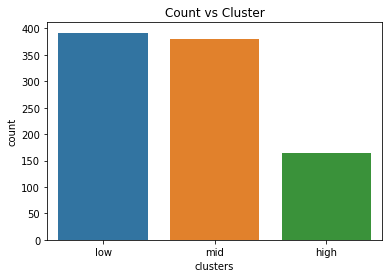

In [69]:
plt.figure(figsize=(6,4))
sns.barplot(x=clusters_df['clusters'], y=clusters_df['count'])
plt.title('Count vs Cluster')
plt.show()

To further perform an anlysis on the other features we created, we create a list of `metrics` as follows. Features such as `ride_count` and `average_val` are excluded because they are more or less represented by `average_ride_freq` and `ltv` respectively. We also excluded `driving_period` because `unique_days` is a better measure of a driver's activity.

In [0]:
exclude = ['driver_id', 'ride_count', 'driving_period', 'average_val', 'clusters']
metrics = [col for col in ltv.columns if col not in exclude]

# reorder metrics for plotting
metrics = [ 'fare',
            'average_ride_freq',
            'is_weekday',
            'drop_requested_lag',
            'ride_prime_time',           
            'pickup_window',
            'unique_days',
            'is_late_ride',
            'average_ride_val',
            'ltv']

Plot distribution.

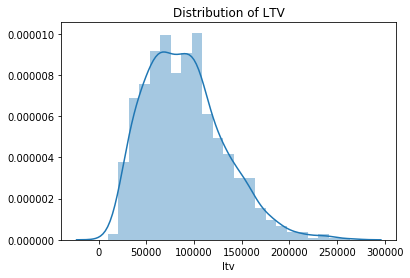

In [71]:
# distrion of LTV
plt.title('Distribution of LTV')
sns.distplot(ltv['ltv'])
plt.show()

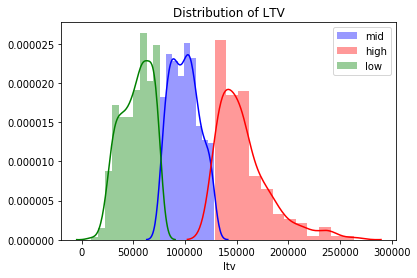

In [72]:
# distrion of LTV based on clusters
plt.title('Distribution of LTV')
fig = plt.subplot()
sns.distplot(ltv[ltv['clusters']==clus_labels['mid']]['ltv'],color ='blue')
sns.distplot(ltv[ltv['clusters']==clus_labels['high']]['ltv'],color ='red')
sns.distplot(ltv[ltv['clusters']==clus_labels['low']]['ltv'],color ='green')    
fig.legend(labels=['mid','high', 'low'])
plt.show()

In [73]:
ltv['ltv'].mean()

90141.93245511132

## Radar chart
We first compute the maximum value for each feature to scale our radar chart later.

In [0]:
scale_max = ltv[metrics].max().values

In [0]:
def radar_cluster(i):
    radar = pd.DataFrame(ltv[ltv['clusters'] == i][metrics].mean()).reset_index()

    radar['r'] = radar.loc[:, 0] / scale_max

    radar.rename(columns={'index': 'theta'}, inplace=True)

    return radar

Plot the radar chart.

In [76]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=radar_cluster(clus_labels['mid'])['r'],
      theta=radar_cluster(clus_labels['mid'])['theta'],
      fill='toself',
    #     fillcolor = '#8A2BE2',
    #    line =  dict(
    #         color = '#8A2BE2',            
    #   ),
    #   opacity=0.7, 
      name='mid'
))
fig.add_trace(go.Scatterpolar(
      r=radar_cluster(clus_labels['high'])['r'],
      theta=radar_cluster(clus_labels['high'])['theta'],
      fill='toself',
    #     fillcolor = '#FF0000',
    #   line =  dict(
    #         color = '#FF0000'
    #   ),
    #   opacity=0.7,          
      name='high'
))
fig.add_trace(go.Scatterpolar(
      r=radar_cluster(clus_labels['low'])['r'],
      theta=radar_cluster(clus_labels['low'])['theta'],
      fill='toself',
    #   fillcolor = '#00FA9A',
    #   line =  dict(
    #         color = '#00FA9A',            
    #   ),
    #   opacity=0.5,
      name='low'
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 0.8]
    )),
  showlegend=True,
  title='Segment of drivers'
)

fig.show()

From this radar chart, we observe that even we only fitted KMeans with the 4 base metrics: `ride_count`, `fare`, `unique_days`, and `ltv` to get 3 clusters, other feature such as `is_weekday` is fairly distinct for the clusters above. We then conclude that `is_weekday` might be a useful feature to help segmenting drivers.

## Visualizations

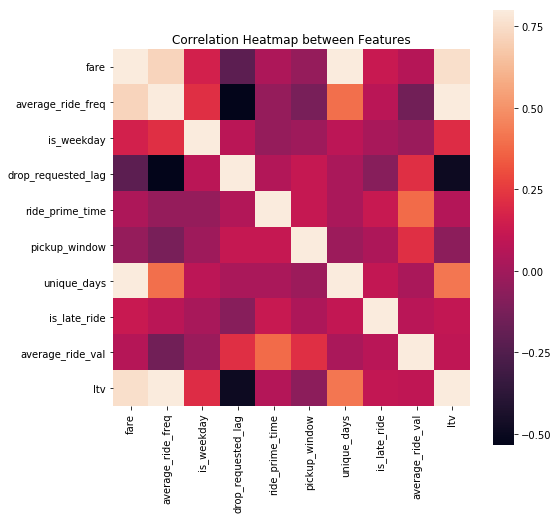

In [77]:
# correlationa matrix of metrics
corr_mat = ltv[metrics].corr()

plt.figure(figsize=(8,8))
plt.title('Correlation Heatmap between Features')
sns.heatmap(corr_mat, vmax=.8, square=True);

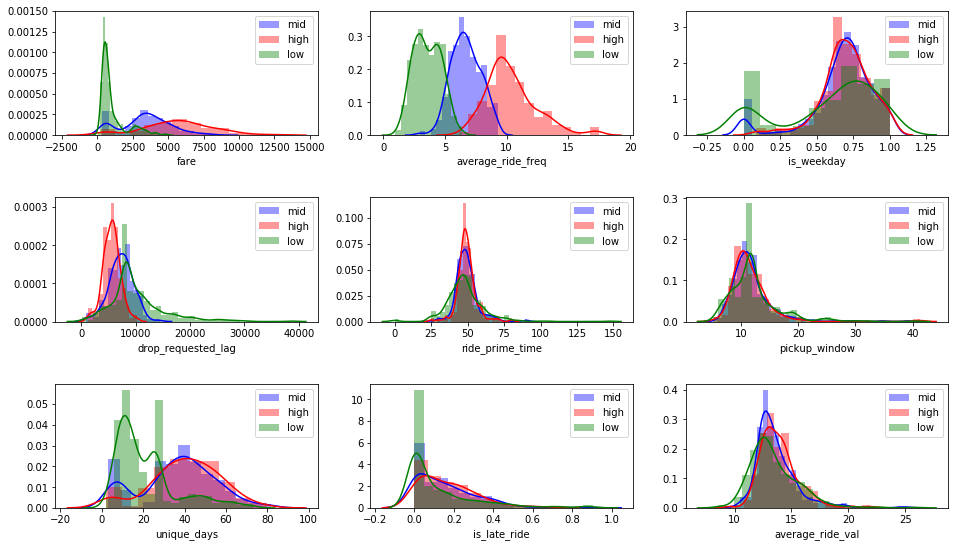

In [78]:
# distribution of metrics
plt.figure(figsize=(16,40))
for i, m in enumerate(metrics[:-1]):
    fig = plt.subplot(12, 3, i+1)    
    sns.distplot(ltv[ltv['clusters']==clus_labels['mid']][m],color ='blue')
    sns.distplot(ltv[ltv['clusters']==clus_labels['high']][m],color ='red')
    sns.distplot(ltv[ltv['clusters']==clus_labels['low']][m],color ='green')    
    plt.subplots_adjust(hspace=0.5)
    fig.legend(labels=['mid','high','low'])
plt.show()

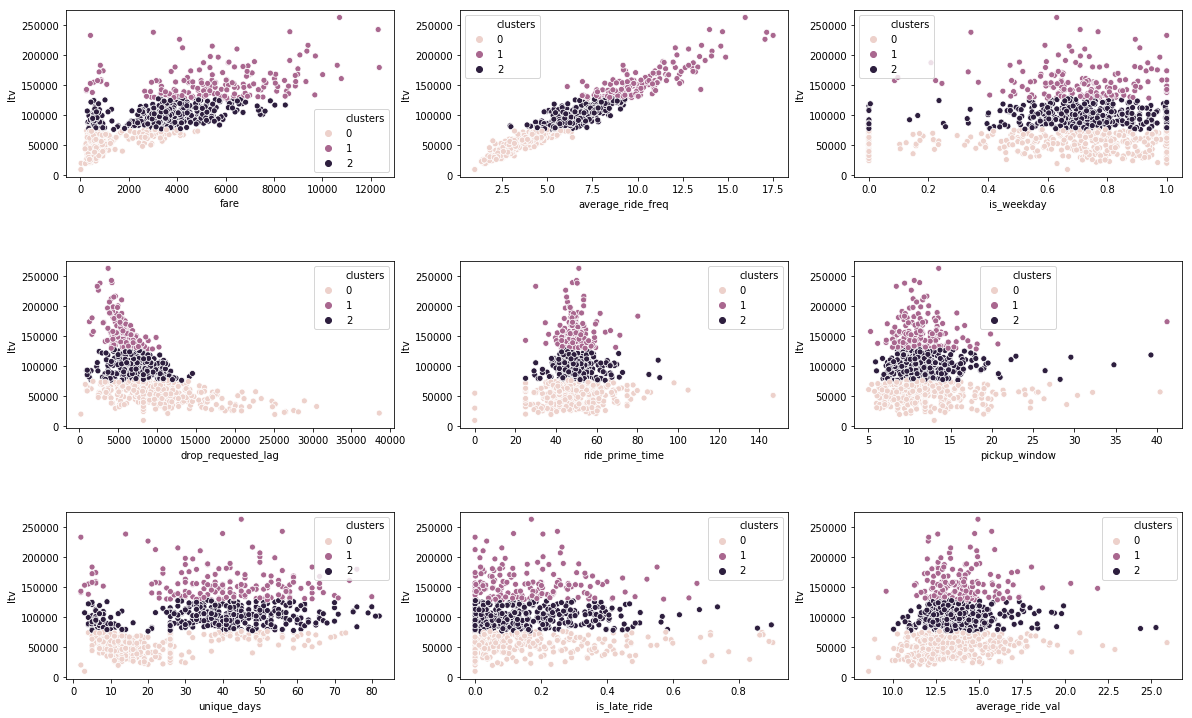

In [79]:
# scatterplot of metrics
plt.figure(figsize=(20,40))
for i, m in enumerate(metrics[:-1]):
    plt.subplot(9, 3, i+1)
    sns.scatterplot(x=ltv[m], y=ltv[metrics[-1]],
                    hue=ltv['clusters'])
    plt.subplots_adjust(hspace=0.5)
    
plt.show()

## Considering all metrics
Showing that using `base_metrics` already allows other features to help us predict which segment a driver will fall into, we proceed to fit the `metrics` to the KMeans algorithm instead of only using the 4 features in `base_metrics`.

In [80]:
metrics

['fare',
 'average_ride_freq',
 'is_weekday',
 'drop_requested_lag',
 'ride_prime_time',
 'pickup_window',
 'unique_days',
 'is_late_ride',
 'average_ride_val',
 'ltv']

In [81]:
# create another df of ltv
scaled_ltv = ltv.copy()

# scale the metrics
scaler = MinMaxScaler()
scaled_ltv[metrics] = scaler.fit_transform(scaled_ltv[metrics])

scaled_ltv.head()

,driver_id,ride_count,drop_requested_lag,ride_prime_time,fare,driving_period,pickup_window,unique_days,is_weekday,is_late_ride,average_ride_val,average_ride_freq,average_val,ltv,clusters
0,002be0ffdc997bd5c50703158b7c2491,277.0,0.167019,0.332689,0.286844,86.0,0.092900,0.675,0.769675,0.264530,0.247527,0.239177,63.587966,0.239848,0
1,007f0389f9c7b03ef97098422f902e62,31.0,0.115483,0.354610,0.024001,85.0,0.187658,0.125,0.709677,0.000000,0.104225,0.095960,26.791246,0.079453,0
2,011e5c5dfc5c2c92501b8b24d47509bc,34.0,0.182397,0.287234,0.037059,68.0,0.062136,0.125,0.529412,0.065110,0.324454,0.111111,40.202366,0.137911,0
3,0152a2f305e71d26cc964f8d4411add9,191.0,0.256453,0.290780,0.209758,64.0,0.252848,0.500,0.796859,0.508813,0.294486,0.215007,62.163609,0.233639,0
4,01674381af7edd264113d4e6ed55ecda,375.0,0.168032,0.323232,0.434530,56.0,0.206696,0.475,1.000000,0.060804,0.333713,0.507576,134.527438,0.549070,1


In [0]:
# get the matrix of metrics values
matrix = scaled_ltv[metrics].values

# call KMeans and fit the metrics values
kmeans = KMeans(n_clusters=CLUSTERS, init='k-means++', n_init=40)
kmeans.fit(matrix)

# predict the clusters
clusters = kmeans.predict(matrix)

# assign to scaled_ltv
scaled_ltv['clusters'] = clusters

In [83]:
scaled_clus_labels = create_label_map(scaled_ltv)    

# Reverse the labels for mapping
scaled_clus_labels = {v: k for k, v in scaled_clus_labels.items()}

scaled_clus_labels

{0: 'mid', 1: 'low', 2: 'high'}

## Indexing
Credits to Françoise Provencher's talk at Montréal-Python 71.

In [84]:
# map back to original clusters
scaled_ltv['clusters'] = scaled_ltv['clusters'].map(scaled_clus_labels)

indexed = scaled_ltv.groupby('clusters').mean()

indexed = indexed[metrics].copy()

indexed

,fare,average_ride_freq,is_weekday,drop_requested_lag,ride_prime_time,pickup_window,unique_days,is_late_ride,average_ride_val,ltv
clusters,,,,,,,,,,
high,0.375135,0.409723,0.712563,0.190533,0.331705,0.183868,0.540343,0.188587,0.286590,0.418355
low,0.086333,0.175741,0.068637,0.194189,0.338929,0.194697,0.244005,0.085179,0.299372,0.196317
mid,0.050948,0.199394,0.763054,0.244751,0.331423,0.195220,0.131840,0.148747,0.294255,0.213170


In [0]:
for metric in metrics:
    indexed[metric] = indexed[metric] - scaled_ltv[metric].mean()
    indexed[metric] = indexed[metric] / indexed[metric].abs().max()

In [86]:
def coloring(val):
    if val < -0.5:
        color = '#d65f5f'
    elif val > 0.5:
        color = '#5fba7d'
    else:
        color = 'white'
    return 'background: %s' % color

table = indexed.T.style.applymap(coloring)

table

clusters,high,low,mid
fare,0.865424,-0.796389,-1
average_ride_freq,0.801416,-1,-0.817896
is_weekday,0.127646,-1,0.216066
drop_requested_lag,-0.535644,-0.432105,1
ride_prime_time,-0.144898,1,-0.189591
pickup_window,-0.896653,0.912724,1
unique_days,0.788273,-0.508985,-1
is_late_ride,0.370918,-1,-0.157257
average_ride_val,-0.522803,1,0.390339
ltv,0.829588,-1,-0.861129


From the table above, we can see that `fare`, `average_ride_freq`, `unique_days` and `ltv` are high in high value cluster.

## UMAP
We also attempted to perform UMAP on the metrices. It seems like we are able to separate each cluster out distinctly based in 2D projections.

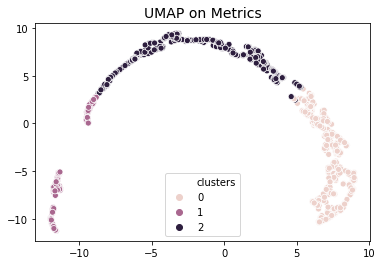

In [87]:
reducer = umap.UMAP()

# fit UMAP on all the metrics
embedding = reducer.fit_transform(ltv[metrics])

plt.title('UMAP on Metrics', fontsize=14)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],
                hue=ltv['clusters'])
plt.show()